In [1]:
### v1.1

# Task 1: Bear and Non-bear classification using transfer learning: Comparing MobileNet v2 and MobileNet v3Small

## 1 Preprocessing

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2024-08-15 01:10:54.223947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 01:10:54.223986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 01:10:54.224645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 01:10:54.228475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 01:10:54.877578: W tensorflow/compiler/tf2

### 1.1 Create the Dataset and Split it into Training and Validation Sets


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "Datasets/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 954 files belonging to 2 classes.
Using 764 files for training.


2024-08-15 01:10:55.753614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2024-08-15 01:10:55.954331: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 954 files belonging to 2 classes.
Using 190 files for validation.


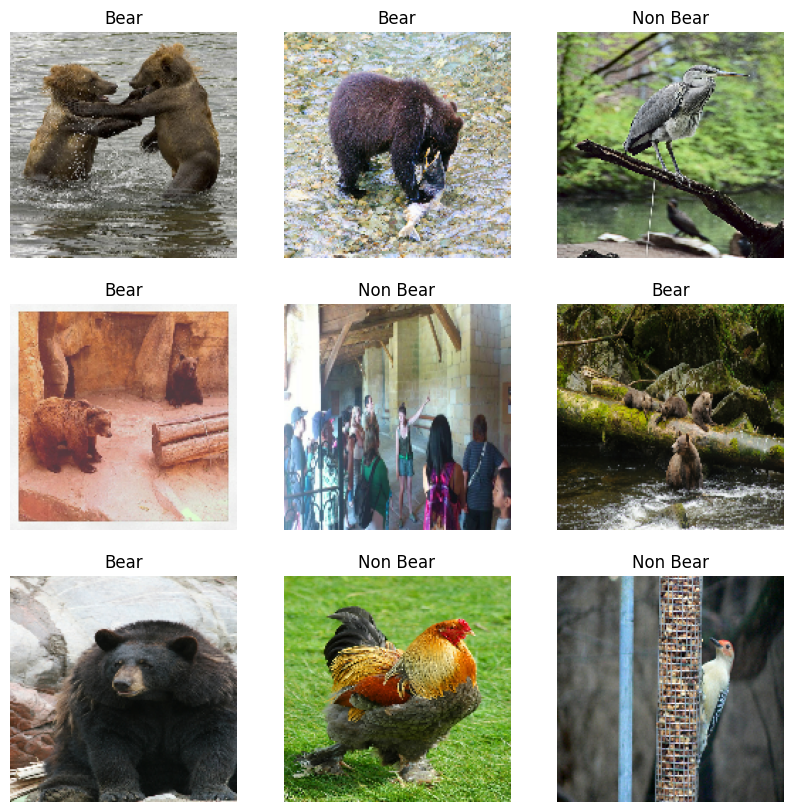

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # take(1) means take a batch which are 32 images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

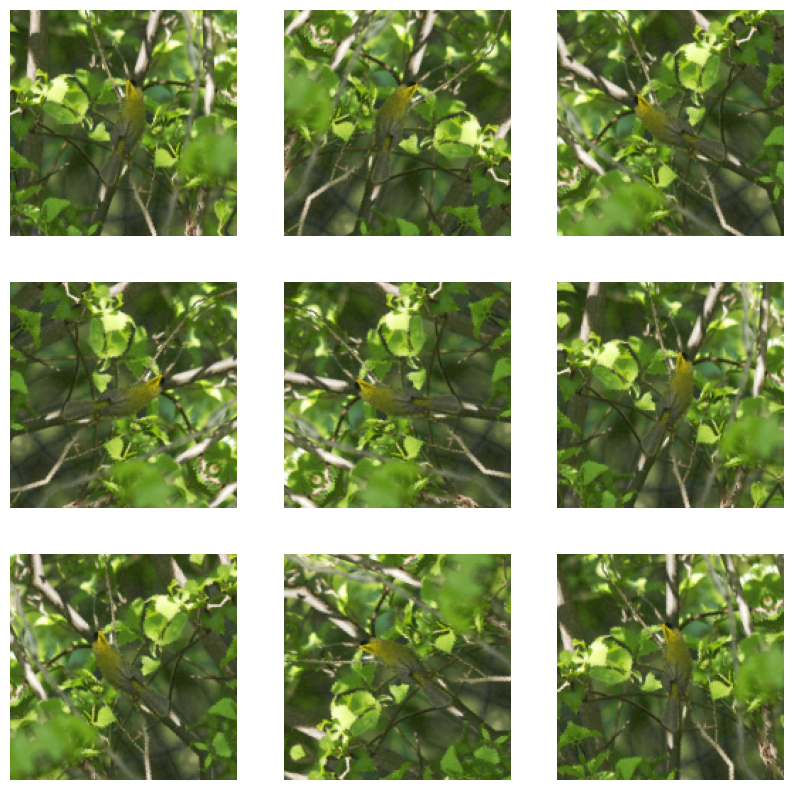

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # tf.expand_dims(first_image, 0): from (160, 160, 3) to (1, 160, 160, 3)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) 
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 2 MobileNet V2

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
##
IMG_SIZE+(3,)

(160, 160, 3)

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [11]:
base_model_v2.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [12]:
nb_layers = len(base_model_v2.layers)
print(base_model_v2.layers[nb_layers - 2].name)
print(base_model_v2.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_v2(image_batch)
print(feature_batch.shape)

(32, 1000)


2024-08-15 01:10:59.588884: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-08-15 01:10:59.643910: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [14]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int32)>

In [15]:
base_model_v2.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model_v2(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)


[[('n02132136', 'brown_bear', 0.5237344),
  ('n02134418', 'sloth_bear', 0.104323044)],
 [('n02408429', 'water_buffalo', 0.26751885),
  ('n01871265', 'tusker', 0.15973349)],
 [('n02132136', 'brown_bear', 0.538636),
  ('n02137549', 'mongoose', 0.048626356)],
 [('n01514668', 'cock', 0.7717384), ('n01514859', 'hen', 0.103517845)],
 [('n02133161', 'American_black_bear', 0.74476695),
  ('n02132136', 'brown_bear', 0.17994045)],
 [('n01729322', 'hognose_snake', 0.81890273),
  ('n01744401', 'rock_python', 0.04351078)],
 [('n02128925', 'jaguar', 0.6294387), ('n02128385', 'leopard', 0.10762815)],
 [('n02727426', 'apiary', 0.9956558), ('n04515003', 'upright', 0.0005768277)],
 [('n02132136', 'brown_bear', 0.5899011),
  ('n02487347', 'macaque', 0.024400476)],
 [('n02132136', 'brown_bear', 0.92814285),
  ('n02102480', 'Sussex_spaniel', 0.008017812)],
 [('n01819313', 'sulphur-crested_cockatoo', 0.6286127),
  ('n02006656', 'spoonbill', 0.017938782)],
 [('n02132136', 'brown_bear', 0.92272556),
  ('n0213

#### Brown bear is already in the label. We do not need exact types of other classes, so we just change it to a binary classifier 

In [16]:
def bear_model_v2(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 160, 160, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 160, 160, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 160, 160, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [17]:
model_v2 = bear_model_v2(IMG_SIZE, data_augmentation)

In [18]:
base_learning_rate = 0.001
model_v2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# Add callback
# callback = tf.keras.callbacks.EarlyStopping(patience=4)
initial_epochs = 50
# history_v2 = model_v2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v2 = model_v2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
 4/24 [====>.........................] - ETA: 0s - loss: 0.6053 - accuracy: 0.6875  

2024-08-15 01:11:03.677048: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd2789acca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-15 01:11:03.677087: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-08-15 01:11:03.680734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723677063.736592  436199 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 5s 76ms/step - loss: 0.4160 - accuracy: 0.7997 - val_loss: 0.2413 - val_accuracy: 0.9158
Epoch 2/50
24/24 [==============================] - 1s 31ms/step - loss: 0.2167 - accuracy: 0.9149 - val_loss: 0.1556 - val_accuracy: 0.9526
Epoch 3/50
24/24 [==============================] - 1s 31ms/step - loss: 0.1778 - accuracy: 0.9332 - val_loss: 0.1370 - val_accuracy: 0.9632
Epoch 4/50
24/24 [==============================] - 1s 31ms/step - loss: 0.1564 - accuracy: 0.9437 - val_loss: 0.1196 - val_accuracy: 0.9579
Epoch 5/50
24/24 [==============================] - 1s 32ms/step - loss: 0.1341 - accuracy: 0.9516 - val_loss: 0.1109 - val_accuracy: 0.9579
Epoch 6/50
24/24 [==============================] - 1s 30ms/step - loss: 0.1337 - accuracy: 0.9542 - val_loss: 0.1031 - val_accuracy: 0.9579
Epoch 7/50
24/24 [==============================] - 1s 30ms/step - loss: 0.1227 - accuracy: 0.9529 - val_loss: 0.0995 - val_accuracy: 0.9632
Epoch 8/50
24/24 [======

Plot the training and validation accuracy:

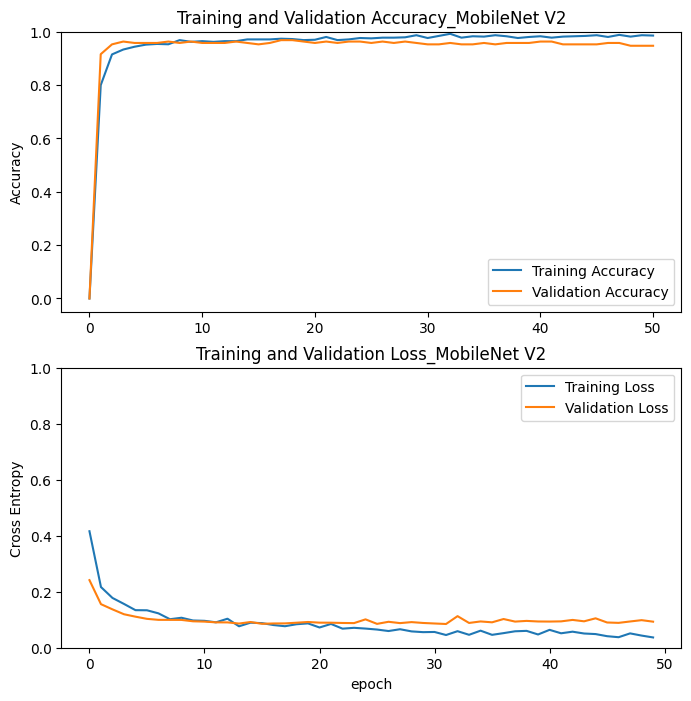

In [20]:
acc_v2 = [0.] + history_v2.history['accuracy']
val_acc_v2 = [0.] + history_v2.history['val_accuracy']

loss_v2 = history_v2.history['loss']
val_loss_v2 = history_v2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v2, label='Training Accuracy')
plt.plot(val_acc_v2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_MobileNet V2')

plt.subplot(2, 1, 2)
plt.plot(loss_v2, label='Training Loss')
plt.plot(val_loss_v2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_MobileNet V2')
plt.xlabel('epoch')
plt.show()

In [21]:
class_names

['Bear', 'Non Bear']

## 3 MobileNetV3 Small

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [23]:
IMG_SIZE+(3,)

(160, 160, 3)

In [24]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v3_s = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
# base_model_v3.summary()

In [25]:
nb_layers = len(base_model_v3_s.layers)
print(base_model_v3_s.layers[nb_layers - 2].name)
print(base_model_v3_s.layers[nb_layers - 1].name)

flatten
Predictions


In [26]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_v3_s(image_batch)
print(feature_batch.shape)

(32, 1000)


In [27]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=int32)>

In [28]:
base_model_v3_s.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model_v3_s(image_var)

tf.keras.applications.mobilenet_v3.decode_predictions(pred.numpy(), top=2)


[[('n02132136', 'brown_bear', 0.33103317),
  ('n02397096', 'warthog', 0.10186086)],
 [('n02396427', 'wild_boar', 0.2504767), ('n01877812', 'wallaby', 0.20844164)],
 [('n03770439', 'miniskirt', 0.14995615), ('n04136333', 'sarong', 0.13033804)],
 [('n02111889', 'Samoyed', 0.26709217),
  ('n02110185', 'Siberian_husky', 0.1020156)],
 [('n13040303', 'stinkhorn', 0.16205806),
  ('n01688243', 'frilled_lizard', 0.11449265)],
 [('n02687172', 'aircraft_carrier', 0.35494027),
  ('n06874185', 'traffic_light', 0.13615791)],
 [('n02132136', 'brown_bear', 0.9768306), ('n02129165', 'lion', 0.004266559)],
 [('n04111531', 'rotisserie', 0.6012805),
  ('n01664065', 'loggerhead', 0.07889258)],
 [('n03445924', 'golfcart', 0.3653473), ('n03899768', 'patio', 0.21801595)],
 [('n02132136', 'brown_bear', 0.85616875), ('n02417914', 'ibex', 0.014962102)],
 [('n02138441', 'meerkat', 0.2949637),
  ('n02437312', 'Arabian_camel', 0.19844793)],
 [('n03877845', 'palace', 0.2698311), ('n04005630', 'prison', 0.18074161)],

In [29]:
def bear_model_v3_s(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV3 Small model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 160, 160, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 160, 160, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 160, 160, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [30]:
model_v3_s = bear_model_v3_s(IMG_SIZE, data_augmentation)

In [31]:
# callback = tf.keras.callbacks.EarlyStopping(patience=5)
base_learning_rate = 0.001
model_v3_s.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 50
# history_v3_s = model_v3_s.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v3_s = model_v3_s.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
24/24 [==============================] - 4s 78ms/step - loss: 0.7144 - accuracy: 0.5628 - val_loss: 0.4950 - val_accuracy: 0.7211
Epoch 2/50
24/24 [==============================] - 1s 29ms/step - loss: 0.4439 - accuracy: 0.7644 - val_loss: 0.3186 - val_accuracy: 0.8474
Epoch 3/50
24/24 [==============================] - 1s 27ms/step - loss: 0.3208 - accuracy: 0.8364 - val_loss: 0.2530 - val_accuracy: 0.8895
Epoch 4/50
24/24 [==============================] - 1s 29ms/step - loss: 0.2923 - accuracy: 0.8639 - val_loss: 0.2200 - val_accuracy: 0.9000
Epoch 5/50
24/24 [==============================] - 1s 29ms/step - loss: 0.2624 - accuracy: 0.8940 - val_loss: 0.2071 - val_accuracy: 0.9000
Epoch 6/50
24/24 [==============================] - 1s 28ms/step - loss: 0.2314 - accuracy: 0.9018 - val_loss: 0.1832 - val_accuracy: 0.9105
Epoch 7/50
24/24 [==============================] - 1s 29ms/step - loss: 0.2116 - accuracy: 0.9097 - val_loss: 0.1838 - val_accuracy: 0.9158
Epoch 8/50
24

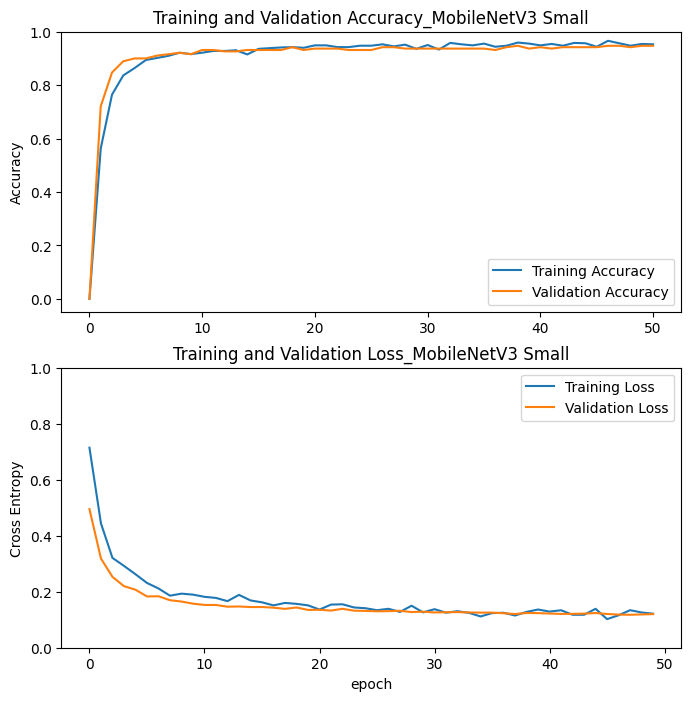

In [32]:
acc_v3_s = [0.] + history_v3_s.history['accuracy']
val_acc_v3_s = [0.] + history_v3_s.history['val_accuracy']

loss_v3_s = history_v3_s.history['loss']
val_loss_v3_s = history_v3_s.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v3_s, label='Training Accuracy')
plt.plot(val_acc_v3_s, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_MobileNetV3 Small')

plt.subplot(2, 1, 2)
plt.plot(loss_v3_s, label='Training Loss')
plt.plot(val_loss_v3_s, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_MobileNetV3 Small')
plt.xlabel('epoch')
plt.show()

## 4 MobileNetV3 Large

In [33]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [34]:
IMG_SIZE+(3,)

(160, 160, 3)

In [35]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v3_l = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
# base_model_v3.summary()

In [36]:
nb_layers = len(base_model_v3_l.layers)
print(base_model_v3_l.layers[nb_layers - 2].name)
print(base_model_v3_l.layers[nb_layers - 1].name)

flatten_1
Predictions


In [37]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_v3_l(image_batch)
print(feature_batch.shape)
print()
print(label_batch)

(32, 1000)

tf.Tensor([1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0], shape=(32,), dtype=int32)


In [38]:
base_model_v3_l.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model_v3_l(image_var)

tf.keras.applications.mobilenet_v3.decode_predictions(pred.numpy(), top=2)


[[('n03814906', 'necklace', 0.3077782),
  ('n01784675', 'centipede', 0.19231753)],
 [('n02102973', 'Irish_water_spaniel', 0.21268913),
  ('n02113799', 'standard_poodle', 0.15506347)],
 [('n02727426', 'apiary', 0.90532535),
  ('n04049303', 'rain_barrel', 0.0022233722)],
 [('n02099849', 'Chesapeake_Bay_retriever', 0.4383054),
  ('n02132136', 'brown_bear', 0.16653213)],
 [('n02396427', 'wild_boar', 0.6060369), ('n01877812', 'wallaby', 0.11975803)],
 [('n02132136', 'brown_bear', 0.57348114), ('n02410509', 'bison', 0.13609205)],
 [('n02132136', 'brown_bear', 0.82457876),
  ('n02133161', 'American_black_bear', 0.03251745)],
 [('n02514041', 'barracouta', 0.95325685), ('n02641379', 'gar', 0.009613176)],
 [('n01978455', 'rock_crab', 0.91022015),
  ('n01978287', 'Dungeness_crab', 0.03348594)],
 [('n02132136', 'brown_bear', 0.87642324),
  ('n02510455', 'giant_panda', 0.02405116)],
 [('n02396427', 'wild_boar', 0.32895863), ('n02363005', 'beaver', 0.04615396)],
 [('n02132136', 'brown_bear', 0.65914

In [39]:
def bear_model_v3_l(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV3Large model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 160, 160, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 160, 160, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 160, 160, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [40]:
model_v3_l = bear_model_v3_l(IMG_SIZE, data_augmentation)
# callback = tf.keras.callbacks.EarlyStopping(patience=4)
base_learning_rate = 0.001
model_v3_l.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 50
# history_v3_l = model_v3_l.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v3_l = model_v3_l.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
24/24 [==============================] - 5s 82ms/step - loss: 0.4921 - accuracy: 0.7500 - val_loss: 0.2565 - val_accuracy: 0.8789
Epoch 2/50
24/24 [==============================] - 1s 30ms/step - loss: 0.2822 - accuracy: 0.8665 - val_loss: 0.1688 - val_accuracy: 0.9158
Epoch 3/50
24/24 [==============================] - 1s 30ms/step - loss: 0.1906 - accuracy: 0.9241 - val_loss: 0.1351 - val_accuracy: 0.9474
Epoch 4/50
24/24 [==============================] - 1s 31ms/step - loss: 0.1793 - accuracy: 0.9372 - val_loss: 0.1229 - val_accuracy: 0.9474
Epoch 5/50
24/24 [==============================] - 1s 30ms/step - loss: 0.1523 - accuracy: 0.9411 - val_loss: 0.1135 - val_accuracy: 0.9474
Epoch 6/50
24/24 [==============================] - 1s 30ms/step - loss: 0.1446 - accuracy: 0.9398 - val_loss: 0.1079 - val_accuracy: 0.9632
Epoch 7/50
24/24 [==============================] - 1s 30ms/step - loss: 0.1279 - accuracy: 0.9424 - val_loss: 0.1000 - val_accuracy: 0.9579
Epoch 8/50
24

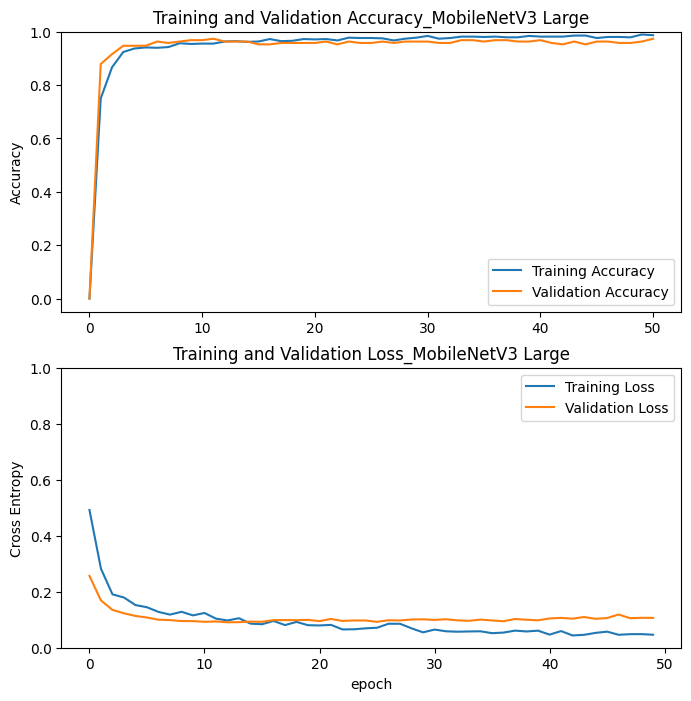

In [41]:
acc_v3_l = [0.] + history_v3_l.history['accuracy']
val_acc_v3_l = [0.] + history_v3_l.history['val_accuracy']

loss_v3_l = history_v3_l.history['loss']
val_loss_v3_l = history_v3_l.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v3_l, label='Training Accuracy')
plt.plot(val_acc_v3_l, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_MobileNetV3 Large')

plt.subplot(2, 1, 2)
plt.plot(loss_v3_l, label='Training Loss')
plt.plot(val_loss_v3_l, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_MobileNetV3 Large')
plt.xlabel('epoch')
plt.show()

## 5 Compare 3 models performance 

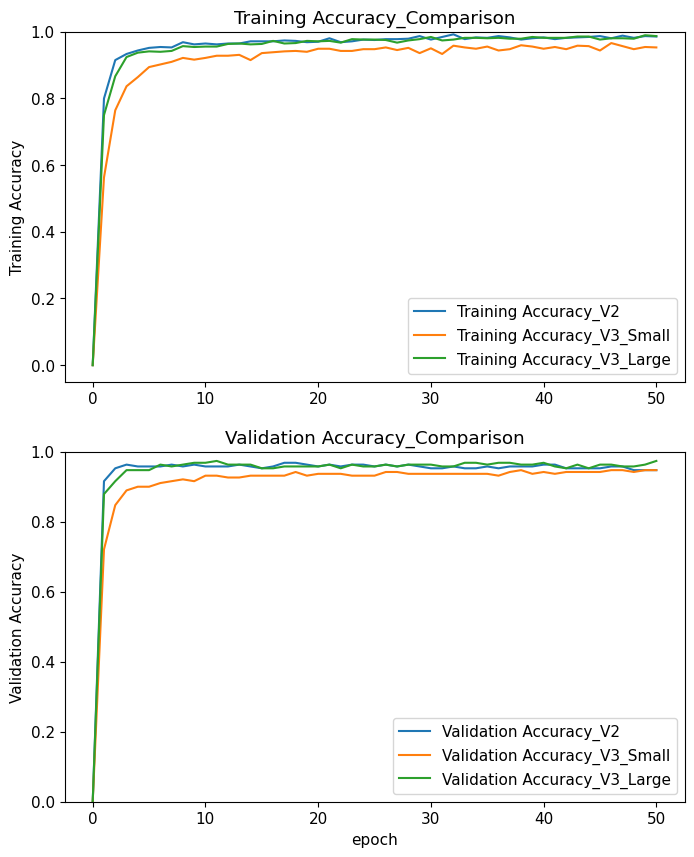

In [83]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(acc_v2, label='Training Accuracy_V2')
plt.plot(acc_v3_s, label='Training Accuracy_V3_Small')
plt.plot(acc_v3_l, label='Training Accuracy_V3_Large')

plt.legend(loc='lower right')
plt.ylabel('Training Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy_Comparison')

plt.subplot(2, 1, 2)
plt.plot(val_acc_v2, label='Validation Accuracy_V2')
plt.plot(val_acc_v3_s, label='Validation Accuracy_V3_Small')
plt.plot(val_acc_v3_l, label='Validation Accuracy_V3_Large')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.ylim([0,1.0])
plt.title('Validation Accuracy_Comparison')
plt.xlabel('epoch')
plt.show()

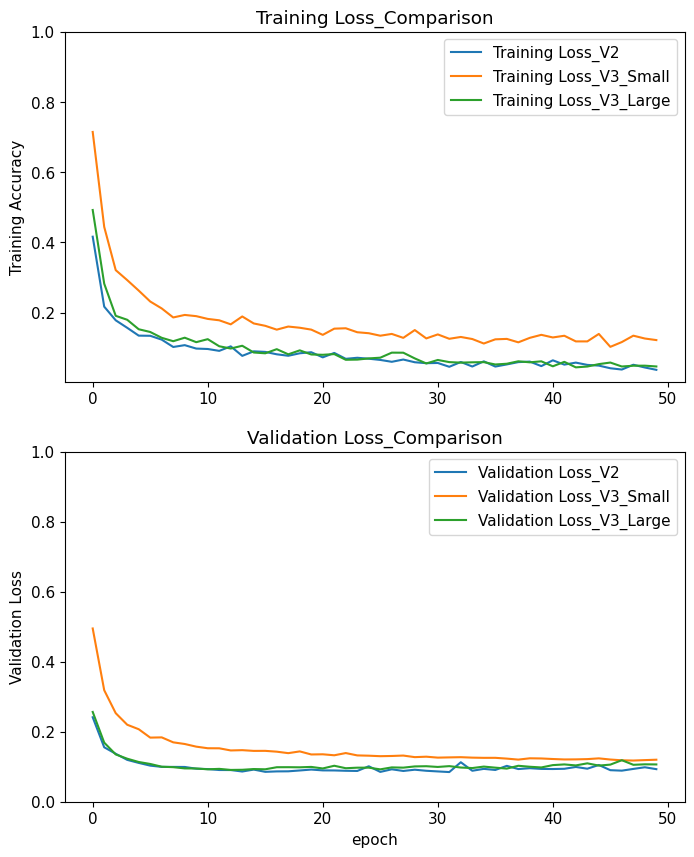

In [84]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_v2, label='Training Loss_V2')
plt.plot(loss_v3_s, label='Training Loss_V3_Small')
plt.plot(loss_v3_l, label='Training Loss_V3_Large')

plt.legend(loc='upper right')
plt.ylabel('Training Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Loss_Comparison')

plt.subplot(2, 1, 2)
plt.plot(val_loss_v2, label='Validation Loss_V2')
plt.plot(val_loss_v3_s, label='Validation Loss_V3_Small')
plt.plot(val_loss_v3_l, label='Validation Loss_V3_Large')
plt.legend(loc='upper right')
plt.ylabel('Validation Loss')
plt.ylim([0,1.0])
plt.title('Validation Loss_Comparison')
plt.xlabel('epoch')
plt.show()

## 6 Yolo

In [44]:
import os
from ultralytics import YOLO
# numpy 1,24.2

In [45]:
DATA_DIR = '/home/jupyter-yixuan/project_machine_learning/Yolo_bear_non_bear'

In [46]:
# Load a model
model = YOLO("yolov8n-cls.pt")  # load a pretained model

# Use the model
results = model.train(data=DATA_DIR, epochs=50, imgsz=160)  # train the model

/home/jupyter-yixuan/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu

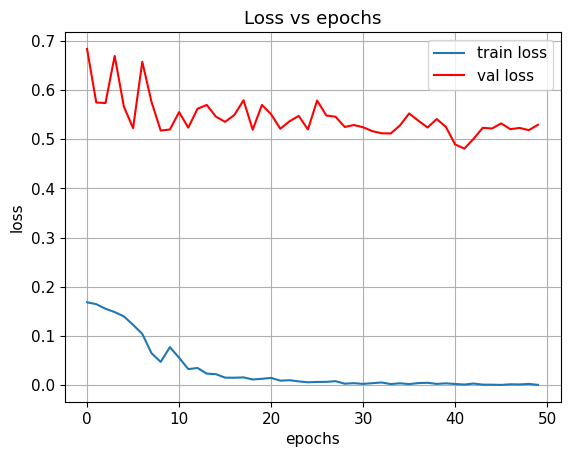

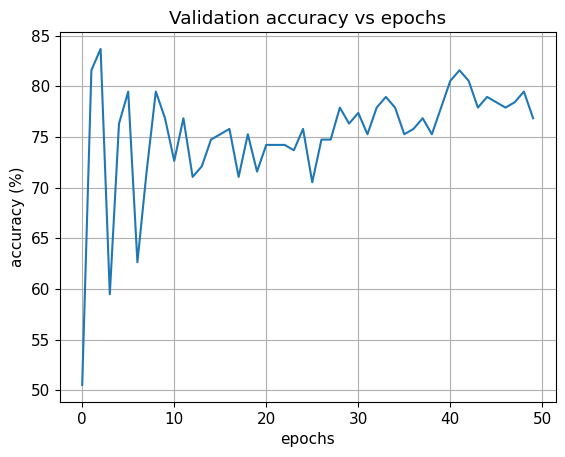

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt

results_path = '/home/jupyter-yixuan/project_machine_learning/runs/classify/train12/results.csv'
results = pd.read_csv(results_path)
results.head()
%matplotlib inline
plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [61]:
results.columns

Index(['                  epoch', '             train/loss',
       '  metrics/accuracy_top1', '  metrics/accuracy_top5',
       '               val/loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')

### Predict

In [62]:
from ultralytics import YOLO

import numpy as np

model_path = '/home/jupyter-yixuan/project_machine_learning/runs/classify/train12/weights/best.pt'
example_path = '/home/jupyter-yixuan/project_machine_learning/angry_bears/images/18.jpeg'

model = YOLO(model_path)  # load a custom model

predict = model(example_path)  # predict on an image

names_dict = predict[0].names

probs = predict[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

/home/jupyter-yixuan/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu

{0: 'Bear', 1: 'Non Bear'}
[0.1856391876935959, 0.8143608570098877]
Non Bear


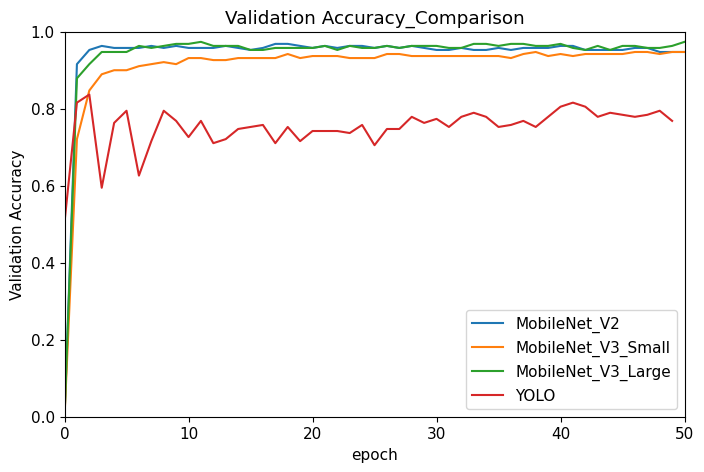

In [82]:

plt.figure(figsize=(8,5))
plt.plot(val_acc_v2, label='MobileNet_V2')
plt.plot(val_acc_v3_s, label='MobileNet_V3_Small')
plt.plot(val_acc_v3_l, label='MobileNet_V3_Large')

plt.xlim([0,50])
plt.ylim([0,1.0])

plt.plot( results['  metrics/accuracy_top1'], label = 'YOLO')
# plt.grid()
plt.title('Validation accuracy vs epochs')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.title('Validation Accuracy_Comparison')
plt.xlabel('epoch')
plt.show()

## 7 Efficient Net

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the pre-trained EfficientNet model without the top classification layers
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,  # Exclude the final classification layers
    weights='imagenet',  # Use ImageNet pre-trained weights
    input_shape=(160, 160, 3)  # Input size to match your data
)

# Freeze the base model
base_model.trainable = False


In [68]:
# Add custom layers on top of the base model
model = models.Sequential([
    base_model,  # Base EfficientNet model
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])


In [69]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [70]:
history_ef = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50  # Adjust based on your data size and convergence
)


Epoch 1/50


2024-08-15 01:23:32.778696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 6s 86ms/step - loss: 0.5484 - accuracy: 0.7173 - val_loss: 0.3828 - val_accuracy: 0.8368
Epoch 2/50
24/24 [==============================] - 1s 33ms/step - loss: 0.3354 - accuracy: 0.8678 - val_loss: 0.2930 - val_accuracy: 0.8895
Epoch 3/50
24/24 [==============================] - 1s 33ms/step - loss: 0.2679 - accuracy: 0.8966 - val_loss: 0.2532 - val_accuracy: 0.9105
Epoch 4/50
24/24 [==============================] - 1s 33ms/step - loss: 0.2314 - accuracy: 0.9136 - val_loss: 0.2292 - val_accuracy: 0.9263
Epoch 5/50
24/24 [==============================] - 1s 33ms/step - loss: 0.2019 - accuracy: 0.9202 - val_loss: 0.2105 - val_accuracy: 0.9316
Epoch 6/50
24/24 [==============================] - 1s 34ms/step - loss: 0.1826 - accuracy: 0.9490 - val_loss: 0.1952 - val_accuracy: 0.9421
Epoch 7/50
24/24 [==============================] - 1s 33ms/step - loss: 0.1744 - accuracy: 0.9437 - val_loss: 0.1835 - val_accuracy: 0.9526
Epoch 8/50
24/24 [======

In [71]:
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f"Test Accuracy: {test_acc:.4f}")

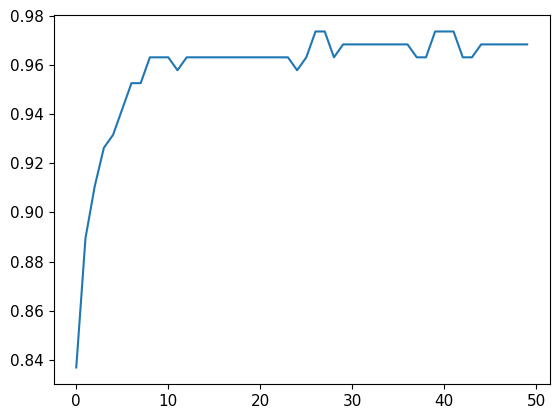

In [72]:
plt.plot(history_ef.history['val_accuracy'], label="Efficient Net")

## 8 Efficient Net V2

In [73]:
from tensorflow.keras.applications import EfficientNetV2B0

# Load the EfficientNetV2 model pre-trained on ImageNet, exclude the top layer
base_model = EfficientNetV2B0(include_top=False, input_shape=(160, 160, 3), weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_ef_v2 = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50


2024-08-15 01:24:33.078292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 7s 93ms/step - loss: 0.6027 - accuracy: 0.6610 - val_loss: 0.3922 - val_accuracy: 0.8632
Epoch 2/50
24/24 [==============================] - 1s 32ms/step - loss: 0.3477 - accuracy: 0.8534 - val_loss: 0.2813 - val_accuracy: 0.9000
Epoch 3/50
24/24 [==============================] - 1s 33ms/step - loss: 0.2810 - accuracy: 0.8887 - val_loss: 0.2368 - val_accuracy: 0.9368
Epoch 4/50
24/24 [==============================] - 1s 32ms/step - loss: 0.2378 - accuracy: 0.9123 - val_loss: 0.2090 - val_accuracy: 0.9368
Epoch 5/50
24/24 [==============================] - 1s 32ms/step - loss: 0.2106 - accuracy: 0.9149 - val_loss: 0.1891 - val_accuracy: 0.9474
Epoch 6/50
24/24 [==============================] - 1s 32ms/step - loss: 0.1845 - accuracy: 0.9490 - val_loss: 0.1734 - val_accuracy: 0.9474
Epoch 7/50
24/24 [==============================] - 1s 32ms/step - loss: 0.1563 - accuracy: 0.9529 - val_loss: 0.1602 - val_accuracy: 0.9579
Epoch 8/50
24/24 [======

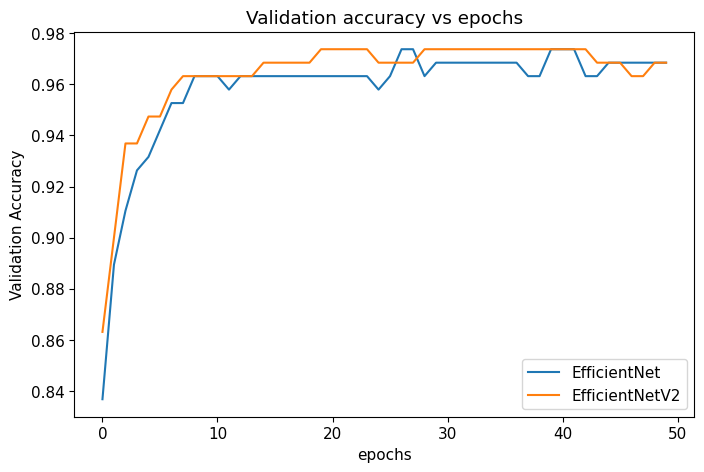

In [81]:
plt.figure(figsize=(8,5))
plt.title('Validation accuracy vs epochs')
plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef_v2.history['val_accuracy'], label="EfficientNetV2")
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')
plt.show()

## 9 Compare 5 models performance 

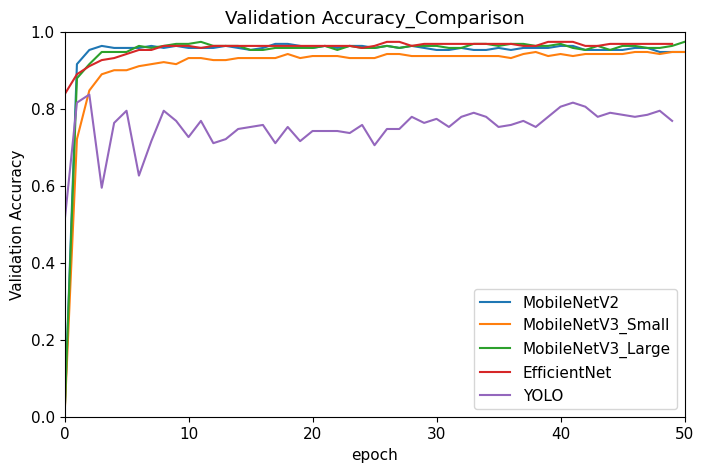

In [79]:
plt.figure(figsize=(8,5))
plt.plot(val_acc_v2, label='MobileNetV2')
plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")

plt.ylim([0,1.0])
plt.xlim([0,50])

plt.plot( results['  metrics/accuracy_top1'], label = 'YOLO')
# plt.grid()
plt.title('Validation accuracy vs epochs')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.title('Validation Accuracy_Comparison')
plt.xlabel('epoch')
plt.show()